In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
holders_anti = ["EE:B4:AF:3F:05:80", # Badge 262
                "FF:0C:74:ED:C4:CD", # Badge 263
                "EC:FB:84:DE:35:4A", # Badge 264
                "C5:85:B9:18:8D:C3", # Badge 265
                "CB:5C:4B:7C:43:81", # Badge 266
                "E1:07:CE:CE:52:BE"] # Badge 267

In [5]:
holders_noanti = ["F1:4E:55:EA:ED:A4", # Badge 210
                  "E8:FA:0D:3C:01:82", # Badge 211
                  "C2:57:36:E6:71:6E", # Badge 212
                  "D9:86:6F:AF:E8:90", # Badge 213
                  "C1:96:24:5B:EB:97", # Badge 214
                  "C8:2F:80:DA:26:94"] # Badge 215

# Open up the test logs and load into dataframes

In [6]:
def load(filename):
    raw = pd.read_csv(filename)
    raw = raw.loc[(raw['RSSI']>-70)]

    at = raw.loc[raw['MAC'].isin(holders_anti)]  # Antistatic Transmitters
    nat = raw.loc[raw['MAC'].isin(holders_noanti)]  # No-Antistatic Transmitters
    allt = pd.concat([at, nat]).sort_values(by="DATETIME")  # All Transmitters (removed unwanted MACs)
    
    return (allt.reset_index(drop=True), at.reset_index(drop=True), nat.reset_index(drop=True))

In [7]:
# Antistatic Receivers
df_ar2, df_ar2at, df_ar2nat = load('logs_antistatic/BLE_range_test_2ft_antistatic_CSV/000.csv')
df_ar4, df_ar4at, df_ar4nat = load('logs_antistatic/BLE_range_test_4ft_antistatic_CSV/000.csv')
df_ar6, df_ar6at, df_ar6nat = load('logs_antistatic/BLE_range_test_6ft_antistatic_CSV/000.csv')
df_ar8, df_ar8at, df_ar8nat = load('logs_antistatic/BLE_range_test_8ft_antistatic_CSV/000.csv')
df_ar10, df_ar10at, df_ar10nat = load('logs_antistatic/BLE_range_test_10ft_antistatic_CSV/000.csv')

In [8]:
# No-Antistatic Receivers
df_nar2, df_nar2at, df_nar2nat = load('logs_noantistatic/BLE_range_test_2ft_noantistatic_CSV/000.csv')
df_nar4, df_nar4at, df_nar4nat = load('logs_noantistatic/BLE_range_test_4ft_noantistatic_CSV/000.csv')
df_nar6, df_nar6at, df_nar6nat = load('logs_noantistatic/BLE_range_test_6ft_noantistatic_CSV/000.csv')
df_nar8, df_nar8at, df_nar8nat = load('logs_noantistatic/BLE_range_test_8ft_noantistatic_CSV/000.csv')
df_nar10, df_nar10at, df_nar10nat = load('logs_noantistatic/BLE_range_test_10ft_noantistatic_CSV/000.csv')

# make histograms with rssi vs count

In [9]:
def rolling_format(df, window, func):
    roll = df.drop(columns=["DATETIME", "MAC"]).rolling(window)
    if func == "max":
        roll = roll.max()
    elif func == "mean":
        roll = roll.mean()
    return roll.drop(list(range(window))).reset_index(drop=True)
    

In [10]:
def plot_all_distances(holders, roll=None, vert=None, numbins=8, alph=.75):
    h_str = "Holders: " + holders
    r_str = ""
    v_str = ""
    
    if holders == "antistatic":
        df2 = df_ar2at
        df4 = df_ar4at
        df6 = df_ar6at
        df8 = df_ar8at
        df10 = df_ar10at
    elif holders == "regular":
        df2 = df_nar2nat
        df4 = df_nar4nat
        df6 = df_nar6nat
        df8 = df_nar8nat
        df10 = df_nar10nat
        
    if roll:
        roll_window, roll_func = roll
        r_str = ", Roll: " + str(roll_window) + "-wide " + str(roll_func)
        df2 = rolling_format(df2, roll_window, roll_func)
        df4 = rolling_format(df4, roll_window, roll_func)
        df6 = rolling_format(df6, roll_window, roll_func)
        df8 = rolling_format(df8, roll_window, roll_func)
        df10 = rolling_format(df10, roll_window, roll_func)
    
    plt.hist(df2["RSSI"], bins=numbins, alpha=alph, label='2 ft')
    plt.hist(df4["RSSI"], bins=numbins, alpha=alph, label='4 ft')
    plt.hist(df6["RSSI"], bins=numbins, alpha=alph, label='6 ft')
    plt.hist(df8["RSSI"], bins=numbins, alpha=alph, label='8 ft')
    plt.hist(df10["RSSI"], bins=numbins, alpha=alph, label='10 ft')
    
    if vert:
        v_str = ", Vertical: " + str(vert)
        if vert == "max":
            v2 = df2.max()["RSSI"]
            v4 = df4.max()["RSSI"]
            v6 = df6.max()["RSSI"]
            v8 = df8.max()["RSSI"]
            v10 = df10.max()["RSSI"]
        elif vert == "mean":
            v2 = df2.mean()["RSSI"]
            v4 = df4.mean()["RSSI"]
            v6 = df6.mean()["RSSI"]
            v8 = df8.mean()["RSSI"]
            v10 = df10.mean()["RSSI"]
        plt.axvline(x=v2, color='C0')
        plt.axvline(x=v4, color='C1')
        plt.axvline(x=v6, color='C2')
        plt.axvline(x=v8, color='C3')
        plt.axvline(x=v10, color='C4')
    
    plt.title(h_str + r_str + v_str)
    plt.legend(loc='upper left')
    plt.show()

# Investigate Max/Mean on Raw Data

## Max

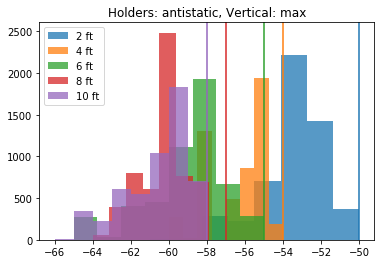

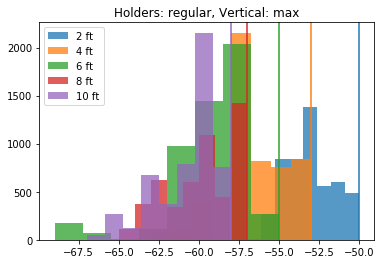

In [11]:
plot_all_distances(holders="antistatic", vert="max")
plot_all_distances(holders="regular", vert="max")

## Mean

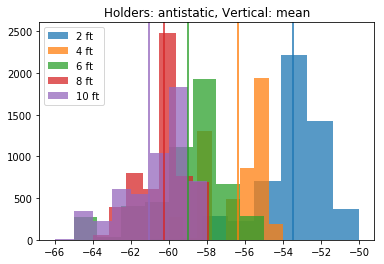

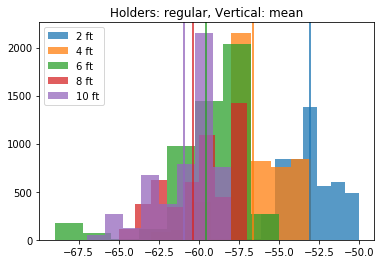

In [12]:
plot_all_distances(holders="antistatic", vert="mean")
plot_all_distances(holders="regular", vert="mean")

# Investigate Max/Mean on Rolling Mean

## Max

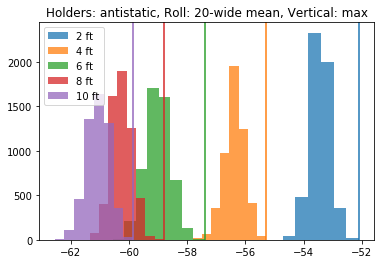

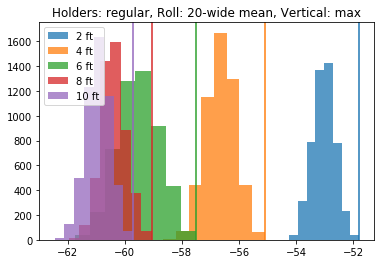

In [13]:
plot_all_distances(holders="antistatic", roll=(20, "mean"), vert="max")
plot_all_distances(holders="regular", roll=(20, "mean"), vert="max")

## Mean

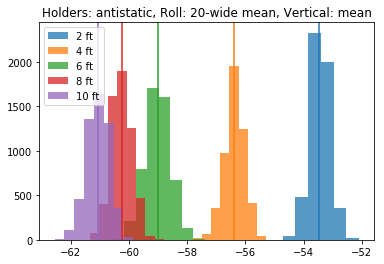

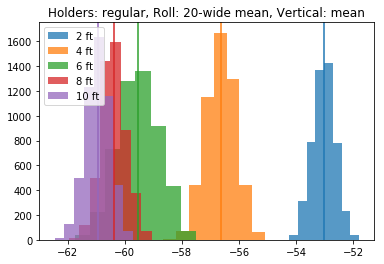

In [14]:
plot_all_distances(holders="antistatic", roll=(20, "mean"), vert="mean")
plot_all_distances(holders="regular", roll=(20, "mean"), vert="mean")

# Investigate Max/Mean on Rolling Max

## Max

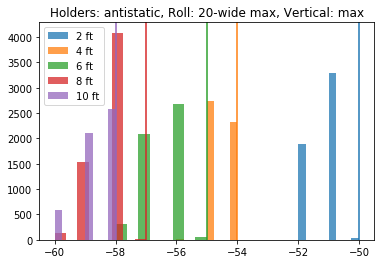

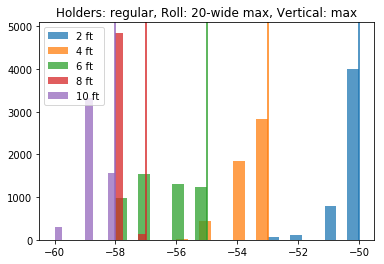

In [15]:
plot_all_distances(holders="antistatic", roll=(20, "max"), vert="max")
plot_all_distances(holders="regular", roll=(20, "max"), vert="max")

## Mean

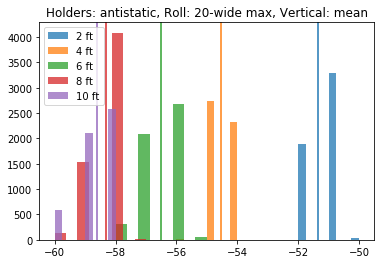

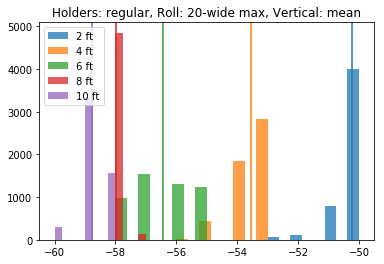

In [16]:
plot_all_distances(holders="antistatic", roll=(20, "max"), vert="mean")
plot_all_distances(holders="regular", roll=(20, "max"), vert="mean")

# Making a predictive model using max of rolling mean

In [17]:
R_anti = np.array([int(rolling_format(df_ar2at, window=20, func="mean").max()),
     int(rolling_format(df_ar4at, window=20, func="mean").max()),
     int(rolling_format(df_ar6at, window=20, func="mean").max()),
     int(rolling_format(df_ar8at, window=20, func="mean").max()),
     int(rolling_format(df_ar10at, window=20, func="mean").max())])
R_reg = np.array([int(rolling_format(df_nar2nat, window=20, func="mean").max()),
     int(rolling_format(df_nar4nat, window=20, func="mean").max()),
     int(rolling_format(df_nar6nat, window=20, func="mean").max()),
     int(rolling_format(df_nar8nat, window=20, func="mean").max()),
     int(rolling_format(df_nar10nat, window=20, func="mean").max())])
R_smpl = np.array(range(
            max(max(R_reg), max(R_anti)), 
            min(min(R_reg), min(R_anti))-1, -1))
D = np.array([2, 4, 6, 8, 10])

###  Exponential Regression

We expect this one to be the most accurate since rssi is in dB (log unit) whereas distance is linear

$a\cdot e^{b\cdot R}=D$

$R:=$ rssi, $D:=$ distance

$\log{D}=\log{a}+b\cdot R$

In [18]:
def D_hat_ereg(r, b, lga):
    return np.exp(lga + b*r)

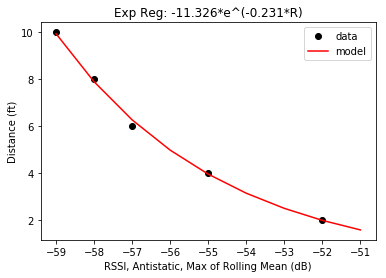

In [19]:
R = R_anti
exp_reg = np.polyfit(R, np.log(D), 1, w=np.sqrt(D))

plt.figure()
plt.plot(R, D, 'ko', label="data")
plt.plot(R_smpl, D_hat_ereg(R_smpl, *exp_reg), 'r-', label="model")
plt.title("Exp Reg: " + str("%.3f" % exp_reg[1]) + "*e^(" 
          + str("%.3f" % exp_reg[0]) + "*R)")
plt.xlabel("RSSI, Antistatic, Max of Rolling Mean (dB)")
plt.ylabel("Distance (ft)")
plt.legend()
plt.show()

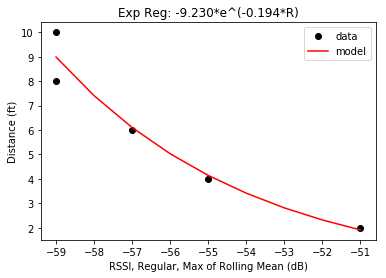

In [20]:
R = R_reg
exp_reg = np.polyfit(R, np.log(D), 1, w=np.sqrt(D))

plt.figure()
plt.plot(R, D, 'ko', label="data")
plt.plot(R_smpl, D_hat_ereg(R_smpl, *exp_reg), 'r-', label="model")
plt.title("Exp Reg: " + str("%.3f" % exp_reg[1]) + "*e^(" 
          + str("%.3f" % exp_reg[0]) + "*R)")
plt.xlabel("RSSI, Regular, Max of Rolling Mean (dB)")
plt.ylabel("Distance (ft)")
plt.legend()
plt.show()

###  Quadratic Regression

This will probably approximate the curve relatively well because there is only a small range of values for which the RSSI is considered valid and noise-free:  (-30, -80)

$a\cdot R^2+b\cdot R+c=D$

In [21]:
def D_hat_qreg(r, a, b, c):
    return c+r*(b+r*a)

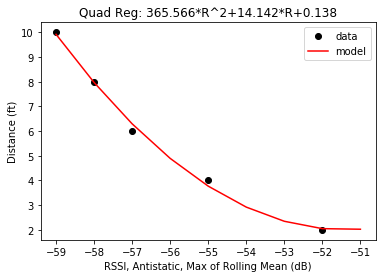

In [22]:
R = R_anti
quad_reg = np.polyfit(R, D, 2)

plt.figure()
plt.plot(R, D, 'ko', label="data")
plt.plot(R_smpl, D_hat_qreg(R_smpl, *quad_reg), 'r-', label="model")
plt.title("Quad Reg: " + str("%.3f" % quad_reg[2]) + "*R^2+" 
          + str("%.3f" % quad_reg[1]) + "*R+" + str("%.3f" % quad_reg[0]))
plt.xlabel("RSSI, Antistatic, Max of Rolling Mean (dB)")
plt.ylabel("Distance (ft)")
plt.legend()
plt.show()

###  Linear Regression

Just for kicks, I'll do a linear regression to see if I can get a decent $r^2$ but I'm not expecting much

$a\cdot R+b=D$

In [23]:
def D_hat_lreg(r, a, b):
    return b+r*a

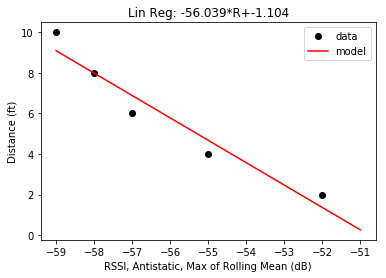

In [24]:
R = R_anti
quad_reg = np.polyfit(R, D, 1)

plt.figure()
plt.plot(R, D, 'ko', label="data")
plt.plot(R_smpl, D_hat_lreg(R_smpl, *quad_reg), 'r-', label="model")
plt.title("Lin Reg: " + str("%.3f" % quad_reg[1]) + "*R+" + str("%.3f" % quad_reg[0]))
plt.xlabel("RSSI, Antistatic, Max of Rolling Mean (dB)")
plt.ylabel("Distance (ft)")
plt.legend()
plt.show()

Well that was dumb